# Exploring biases in WSTAT in Sherpa

[Sherpa](https://sherpa.readthedocs.io/) - although in this context the [CIAO version](https://cxc.cfa.harvard.edu/sherpa/) may be more appropriate - provides two versions of the
[XSPEC CSTAT statistic](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XSappendixStatistics.html), confusingly labelled

- [CStat](https://sherpa.readthedocs.io/en/4.15.1/statistics/api/sherpa.stats.CStat.html)
- [WStat](https://sherpa.readthedocs.io/en/4.15.1/statistics/api/sherpa.stats.WStat.html)

The `CStat` variant is used when you do not have a background (or are just ignoring it), and the `WStat` version allows you to include the background - by treating the background as `n` free parameters (one for each channel) and fitting for them.
It is this latter form that the [Bias In Profile Poisson Likelihood](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/) page by [Giacomo Vianello](https://giacomov.github.io/) discusses.

I wanted to implement Giacomo's analysis in Sherpa: as we already have the code set up this is much more mechanical, and much less mathematically appealing, than Giacomo's presentation! This is also quite a slow notebook to run.

First let's import things:

In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
from sherpa.astro import ui
from sherpa.utils.logging import SherpaVerbosity

In [3]:
import sherpa
# This might not refer to a released version of CIAO ;-)
print(sherpa.__version__)

4.16.0


In [4]:
# fit using wstat
ui.set_stat("wstat")
ui.set_method("simplex")

Here is the code to generate a dataset. In this case it has been converted to use Sherpa's data-management layer, which requires creating "ideal" responses (in this case a RMF with a delta response), setting up the BACKSCAL and exposure values, and
using the "new" NumPy random API rather than the old "global state" version:

In [5]:
def generate_data(rng, n_bins, src_rate, bkg_rate):
    start = 1.0  # keV
    stop = 10.0  # keV

    dE = (stop - start) / n_bins

    edges = np.linspace(start, stop, n_bins + 1)
    observation = rng.poisson((src_rate + bkg_rate) * dE, n_bins).astype(float)
    background = rng.poisson(bkg_rate * dE, n_bins).astype(float)

    channels = np.arange(1, n_bins + 1)
    ui.load_arrays(1, channels, observation, ui.DataPHA)
    
    # fill in some values we need
    ui.set_exposure(1)
    ui.set_backscal(1)
    
    # unfortunately we don't make it easy to create a background dataset, so do it manually
    bkg = ui.DataPHA("bkg", channels, background)
    ui.set_bkg(1, bkg)
    ui.set_exposure(1, bkg_id=1)
    ui.set_backscal(1, bkg_id=1)
    
    # create an ideal RMF to map from channel to energy
    #
    elo = edges[:-1]
    ehi = edges[1:]
    rmf = ui.create_rmf(elo, ehi, e_min=elo, e_max=ehi)
    ui.set_rmf(rmf)
    ui.set_rmf(rmf, bkg_id=1)

    # In CIAO 4.16 this gets a bit chatty which turns out to be annoying below!
    with SherpaVerbosity("ERROR"):
        ui.set_analysis(1, "energy", type="counts")

In [6]:
# To match the original code, use the RandomState class rather than calling np.random.default_rng()
rng = np.random.RandomState(0)

In [7]:
source_rate = 30.0
background_rate = 50.0
number_of_bins = 10

In [8]:
generate_data(rng, number_of_bins, source_rate, background_rate)

In [9]:
# Let's tweak the plot output
pprefs = ui.get_plot_prefs("data")
pprefs["xerrorbars"] = True

# CIAO 4.16 added get_plot_prefs which means setting the background is a lot
# easier than it was in prior versions.
bprefs = ui.get_plot_prefs("bkg")
bprefs["xerrorbars"] = True

ui.set_analysis(1, "energy", type="counts")

dataset 1: 1:10 Energy (keV)


We can now plot the data and background - note that Sherpa uses the `Chi2XspecVar` methood for calculating errors whereas Giacomo's version just used square root of the data values (but as there are no zero-channel bins they should 
be the same):

In [10]:
(np.sqrt(ui.get_data_plot().y) == ui.get_data_plot().yerr).all()

True

Plotting the data we can see a similar shape to the first plot of https://giacomov.github.io/Bias-in-profile-poisson-likelihood/:

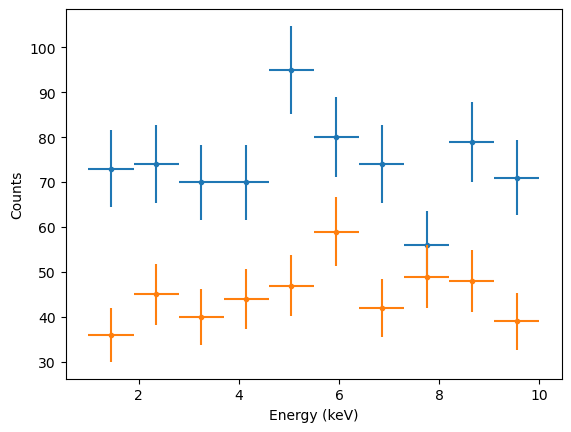

In [11]:
ui.plot_data()
ui.plot_bkg(overplot=True)

We can use the normal Sherpa `fit` command to fit this, after creating a model representing constant emission:

In [12]:
# create the model and get it close to the expected value
ui.set_source(ui.const1d.smdl)
smdl.c0 = source_rate

In [13]:
ui.fit()

Dataset               = 1
Method                = neldermead
Statistic             = wstat
Initial fit statistic = 8.78127
Final fit statistic   = 8.40547 at function evaluation 74
Data points           = 10
Degrees of freedom    = 9
Probability [Q-value] = 0.493856
Reduced statistic     = 0.933942
Change in statistic   = 0.375793
   smdl.c0        32.3455     


So, this seems to match the value that Giacomo calculated - at least to 2 decimal places: `32.35`.

Unfortunately we do not have a nice way to display models when using the WStat statistic, for various technical reasons (XSPEC just subtracts the background so does not need to worry about this, but we do not have that "luxury"), so let's just add in the background values to the model prediction:

In [14]:
mplot = ui.get_model_plot()
bplot = ui.get_bkg_plot()

# add in the background contribution (no concerns about scaling factors here as they are all 1 by design)
mplot.y += bplot.y

Unfortunately, althuogh similar to Giacomo's presentation, it's not exactly the same, in particular around the 5keV and 7 keV bins. This is because we are just adding in the observed background values to the model, whereas Giacomo is showing the fitted background component, and unfortunately we do not have access to those values (it makes sense that these two points are the most-obviously affected, as they are the two vlaues furthest away from the best-fit value, as discussed by Giacomo).

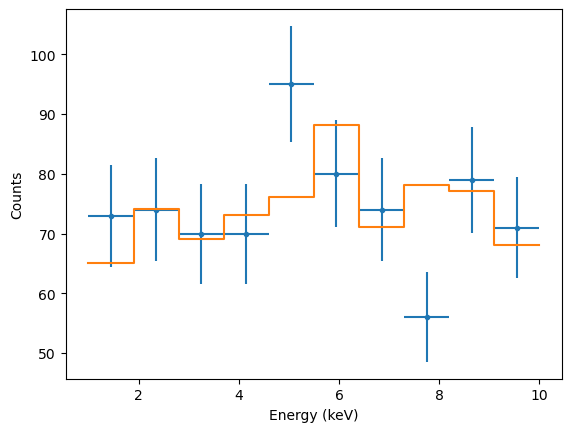

In [15]:
ui.plot_data()
mplot.plot(overplot=True)

Fortunately, as we got the same output - namely the predicted background signal - we can repeat the analysis to look at the biases when the signal in a channel drops to near 0.

To do that, let's create a function that will fit a randomised dataset and return the best-fit value (or `NaN` if the fit fails). This is close to Giacomo's `fit_one_realization` routine.

In [16]:
def do_fit(rng, nbins, srate, brate):
    generate_data(rng, nbins, srate, brate)
    mdl = ui.create_model_component("const1d", "mdlx")
    mdl.c0.set(srate, min=0, max=10 * srate)
    ui.set_source(mdl)
    with SherpaVerbosity("ERROR"):
        ui.fit()

    # Return the best-fit value if it succeeded, otherwise NaN
    fres = ui.get_fit_results()
    if fres.succeeded:
        return mdl.c0.val
    
    return np.nan

I had planned to match the plots created by Giacomo, but it takes a surprising amount of time to do this and I wasn't going to bother with parallelizing the code (as passing through the necessary random state is annoying™), so I've decided to 

- use less iterations
- a slightly-different set of bin numbers (once we get to 1000 bins we find that Sherpa's optimizer has trouble with the fit, and I don't want to spend time exploring tweaking the optimizer here)

In [17]:
source_rate = 30.0
background_rate = 50.0

# We use less bins than Giacomo's version to save some time
# number_of_bins = [50, 100, 200, 400, 500, 1600]
# n_realizations = 16000
# n_realizations = 5000
n_realizations = 2000

# How many bins do we use for the histograms?
# hbins = 80
hbins = 40

In [18]:
res_10 = [do_fit(rng, 10, source_rate, background_rate)
          for j in range(n_realizations)]

In [19]:
res_100 = [do_fit(rng, 100, source_rate, background_rate)
           for j in range(n_realizations)]

In [20]:
res_200 = [do_fit(rng, 200, source_rate, background_rate)
           for j in range(n_realizations)]

In [21]:
res_500 = [do_fit(rng, 500, source_rate, background_rate)
           for j in range(n_realizations)]

In [22]:
res_1000 = [do_fit(rng, 1000, source_rate, background_rate)
            for j in range(n_realizations)]

Can we fit these data sensibly? In other words, were there any bad fits (we could also look for those fits at the minimum or maximum range, but leave that for now)?

In [23]:
def validate(nbins, res):
    res = np.asarray(res)
    nbad = np.isnan(res).sum()
    if nbad > 0:
        print(f"Fit failed {nbad} time(s) for nbins={nbins}")
        res = res[np.isfinite(res)]
        
    print(f"nbins = {nbins:4d}  median = {np.median(res):5.2f}  range {res.min():5.2f} - {res.max():5.2f}")
    return res

In [24]:
res_10 = validate(10, res_10)
res_100 = validate(100, res_100)
res_200 = validate(200, res_200)
res_500 = validate(500, res_500)
res_1000 = validate(1000, res_1000)

nbins =   10  median = 30.06  range 18.06 - 42.49
nbins =  100  median = 30.55  range 12.60 - 45.06
nbins =  200  median = 31.92  range 15.51 - 45.69
nbins =  500  median = 31.75  range  2.00 - 44.68
nbins = 1000  median =  0.00  range  0.00 -  0.00


So, we can see that by 1000 bins we have caused the optimiser in Sherpa to choke, as it always returns a "really small" value ($\sim 6 \times 10^{-14}$)!

In [25]:
res_1000.min(), res_1000.max()

(5.861977570020827e-14, 5.861977570020827e-14)

Plotting up the histograms of the results for the other cases gives us similar shapes to those from Giacomo's work: that is, as the number of bins (a.k.a. channels) increases, so we have "more free parameters", the fit gets more biased.

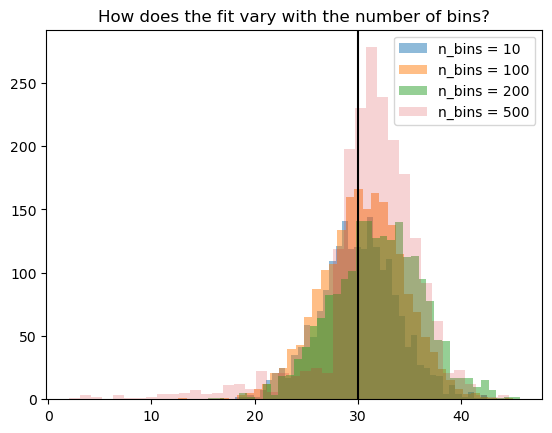

In [26]:
plt.hist(res_10, hbins, alpha=0.5, label="n_bins = 10")
plt.hist(res_100, hbins, alpha=0.5, label="n_bins = 100")
plt.hist(res_200, hbins, alpha=0.5, label="n_bins = 200")
plt.hist(res_500, hbins, alpha=0.2, label="n_bins = 500")  # change opacity as this looks rather different to the other histograms

plt.axvline(source_rate, color='k')
plt.legend()
plt.title("How does the fit vary with the number of bins?");

We can also look at the cumulative distributions (using the Sherpa `plot_cdf` command):

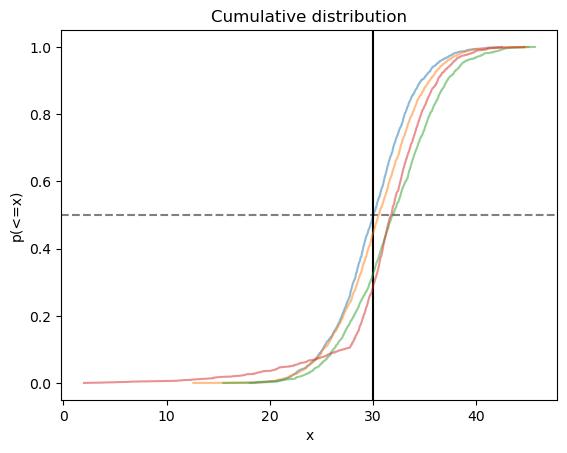

In [27]:
# Turn off the median/sigma ranges
cplot = ui.get_cdf_plot()
cplot.median_defaults["linestyle"] = "noline"
cplot.lower_defaults["linestyle"] = "noline"
cplot.upper_defaults["linestyle"] = "noline"

ui.plot_cdf(res_10, alpha=0.5)
ui.plot_cdf(res_100, alpha=0.5, overplot=True)
ui.plot_cdf(res_200, alpha=0.5, overplot=True)
ui.plot_cdf(res_500, alpha=0.5, overplot=True)

plt.axvline(source_rate, color='k')
plt.axhline(0.5, color='k', alpha=0.5, ls='dashed')
plt.title("Cumulative distribution");

# Rebinning data

We can show that rebinning the data - using the OGIP standard for rebinning PHA data - to show that this can reduce the bias.

First let's check we can re-bin a 200-bin dataset. Here's the data we have been using so far:

In [28]:
generate_data(rng, 200, source_rate, background_rate)

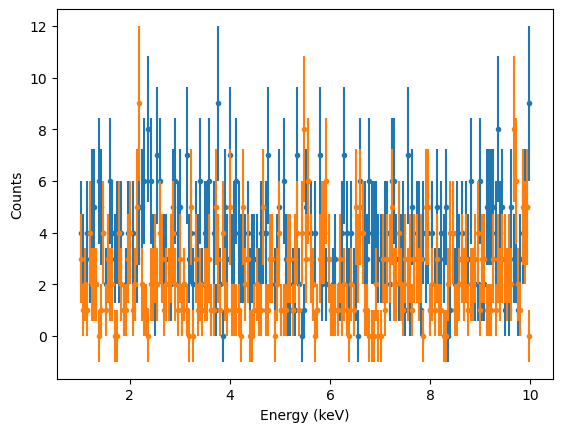

In [29]:
ui.plot_data()
ui.plot_bkg(overplot=True)

It looks like Giacomo's rebinnig approach uses the background data to determine the new bins: we can try this with `ui.group_counts`, although we then need to copy this grouping over to the source dataset (in Sherpa we normally take the grouping from the source and apply it to the background):

In [30]:
# Hide some screen output from group and group_counts in CIAO 4.16
#
with SherpaVerbosity("ERROR"):
    ui.group_counts(1, 5, bkg_id=1)

    ui.get_data().grouping = ui.get_bkg().grouping
    ui.get_data().quality = ui.get_bkg().quality

    ui.group()

We can see that the "effective" number of bins has decreased, and that the source and background regions are using the same binning scheme:

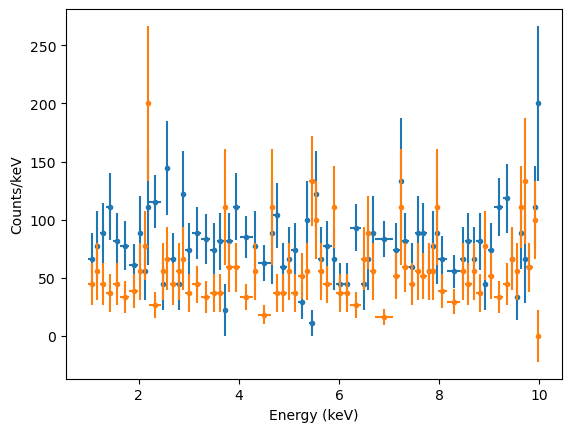

In [31]:
# Let's hide the WARNING messages about the error bars!
with SherpaVerbosity("ERROR"):
    ui.plot_data()
    ui.plot_bkg(overplot=True)

The `do_fit` routine can be tweaked to add this rebinning capability:

In [32]:
def do_fit_rebin(rng, rebin, nbins, srate, brate):
    generate_data(rng, nbins, srate, brate)

    with SherpaVerbosity("ERROR"):
        ui.group_counts(1, rebin, bkg_id=1)

    data = ui.get_data()
    bkg = ui.get_bkg()
    data.grouping = bkg.grouping
    data.quality = bkg.quality
    data.grouped = True

    mdl = ui.create_model_component("const1d", "mdlx")
    mdl.c0.set(srate, min=0, max=10 * srate)
    ui.set_source(mdl)
    with SherpaVerbosity("ERROR"):
        ui.fit()

    # Return the best-fit value if it succeeded, otherwise NaN
    fres = ui.get_fit_results()
    if fres.succeeded:
        return mdl.c0.val
    
    return np.nan

Let's check what happens for 100 bins with rebinning to at least 1, 3, or 5 counts per "group":

In [33]:
res_100_1 = [do_fit_rebin(rng, 1, 100, source_rate, background_rate)
             for j in range(n_realizations)]
res_100_3 = [do_fit_rebin(rng, 3, 100, source_rate, background_rate)
             for j in range(n_realizations)]
res_100_5 = [do_fit_rebin(rng, 5, 100, source_rate, background_rate)
             for j in range(n_realizations)]

For this case the unbinned data looks to result in a slightly-higher model fit, but there's not much difference between the rebinned results (although I hasten to add that this is from a by-eye inspection, and not from a proper review):

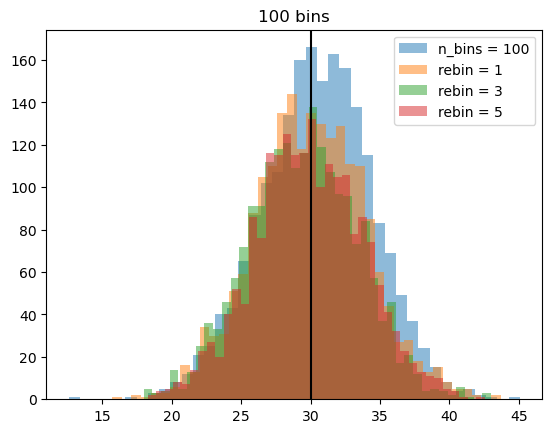

In [34]:
plt.hist(res_100, hbins, alpha=0.5, label="n_bins = 100")
plt.hist(res_100_1, hbins, alpha=0.5, label="rebin = 1")
plt.hist(res_100_3, hbins, alpha=0.5, label="rebin = 3")
plt.hist(res_100_5, hbins, alpha=0.5, label="rebin = 5")

plt.axvline(source_rate, color='k')
plt.legend()
plt.title("100 bins");

If we repeat for 500 bins then we can see the bias much-more strongly (and it's interesting that going to `rebin=1` seems to bias the results to lower than expected):

In [35]:
res_500_1 = [do_fit_rebin(rng, 1, 500, source_rate, background_rate)
             for j in range(n_realizations)]
res_500_3 = [do_fit_rebin(rng, 3, 500, source_rate, background_rate)
             for j in range(n_realizations)]
res_500_5 = [do_fit_rebin(rng, 5, 500, source_rate, background_rate)
             for j in range(n_realizations)]

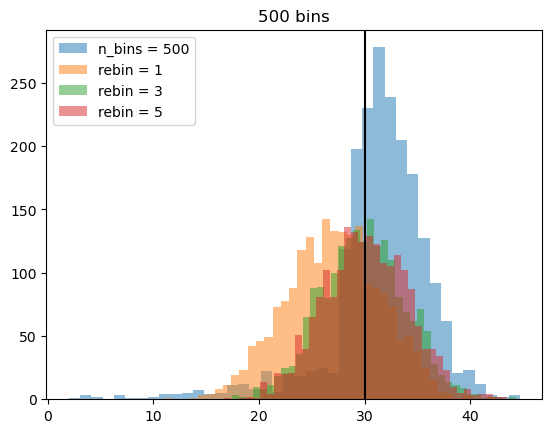

In [36]:
plt.hist(res_500, hbins, alpha=0.5, label="n_bins = 500")
plt.hist(res_500_1, hbins, alpha=0.5, label="rebin = 1")
plt.hist(res_500_3, hbins, alpha=0.5, label="rebin = 3")
plt.hist(res_500_5, hbins, alpha=0.5, label="rebin = 5")

plt.axvline(source_rate, color='k')
plt.legend()
plt.title("500 bins");

What about the 1000-bin case? To (potentially) save time let's go from 5 first, as if that fails then there's no point looking at the smaller rebin factors:

In [37]:
res_1000_5 = [do_fit_rebin(rng, 5, 1000, source_rate, background_rate)
              for j in range(n_realizations)]

In [38]:
res_1000_5 = validate(1000, res_1000_5)

nbins = 1000  median = 30.04  range 18.23 - 44.64


In [39]:
res_1000_3 = [do_fit_rebin(rng, 3, 1000, source_rate, background_rate)
              for j in range(n_realizations)]

In [40]:
res_1000_3 = validate(1000, res_1000_3)

nbins = 1000  median = 30.31  range 16.86 - 45.22


In [41]:
res_1000_1 = [do_fit_rebin(rng, 1, 1000, source_rate, background_rate)
              for j in range(n_realizations)]

In [42]:
res_1000_1 = validate(1000, res_1000_1)

nbins = 1000  median = 28.21  range 12.44 - 42.21


We don't have a sensible "unbinned" dataset to plot, so we just show the rebin results (which look pretty good once we go above rebin=1):

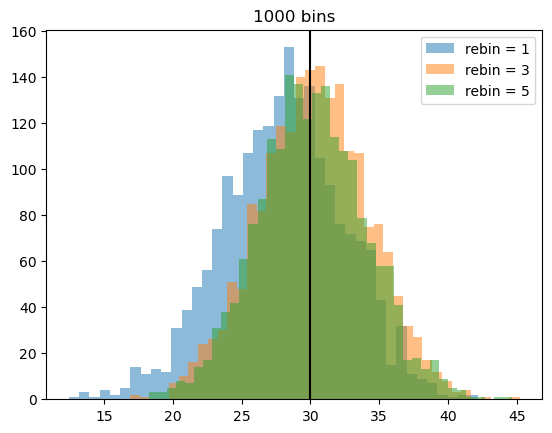

In [43]:
plt.hist(res_1000_1, hbins, alpha=0.5, label="rebin = 1")
plt.hist(res_1000_3, hbins, alpha=0.5, label="rebin = 3")
plt.hist(res_1000_5, hbins, alpha=0.5, label="rebin = 5")

plt.axvline(source_rate, color='k')
plt.legend()
plt.title("1000 bins");

# How about fitting the background?

If you can, we strongly suggest you fit the background, which we do in `do_fit_bkg`, with another constant model. Of course, the difficulty here is that you won't generally know what background model to use!

In [44]:
def do_fit_bkg(rng, nbins, srate, brate):
    generate_data(rng, nbins, srate, brate)
    mdl = ui.create_model_component("const1d", "mdlx")
    mdl.c0.set(srate, min=0, max=10 * srate)
    ui.set_source(mdl)
    
    bmdl = ui.create_model_component("const1d", "mdly")
    bmdl.c0.set(brate, min=0, max=10  * brate)
    ui.set_bkg_source(bmdl)
    
    with SherpaVerbosity("ERROR"):
        ui.fit()

    # Return the best-fit value if it succeeded, otherwise NaN
    fres = ui.get_fit_results()
    if fres.succeeded:
        return mdl.c0.val
    
    return np.nan

For these fits we have to change from the `"wstat"` form of XSPEC's statistic to `"cstat"` (or we could change to `"cash"`, but we want to stay with the XSPEC statistic):

In [45]:
ui.set_stat("cstat")

In [46]:
res_10_bkg = [do_fit_bkg(rng, 10, source_rate, background_rate)
              for j in range(n_realizations)]

In [47]:
res_100_bkg = [do_fit_bkg(rng, 100, source_rate, background_rate)
               for j in range(n_realizations)]

In [48]:
res_500_bkg = [do_fit_bkg(rng, 500, source_rate, background_rate)
               for j in range(n_realizations)]

In [49]:
res_1000_bkg = [do_fit_bkg(rng, 1000, source_rate, background_rate)
                for j in range(n_realizations)]

Plotting up these three cases shows results that look very similar, and without an obvious bias (but again, this is a by-eye analysis, and it is only valid for this very specific setup).

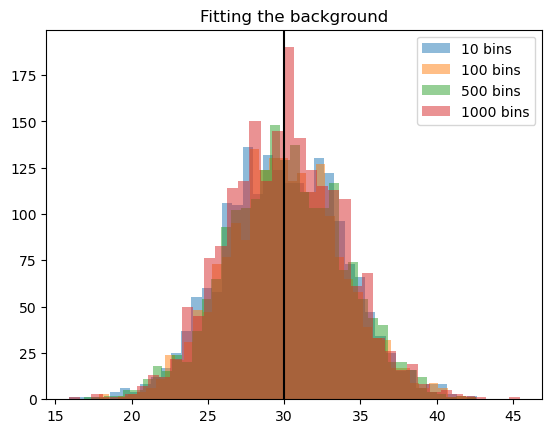

In [50]:
plt.hist(res_10_bkg, hbins, alpha=0.5, label="10 bins")
plt.hist(res_100_bkg, hbins, alpha=0.5, label="100 bins")
plt.hist(res_500_bkg, hbins, alpha=0.5, label="500 bins")
plt.hist(res_1000_bkg, hbins, alpha=0.5, label="1000 bins")

plt.axvline(source_rate, color="k")
plt.legend()
plt.title("Fitting the background");

For completeness, here's the cumulative distributions:

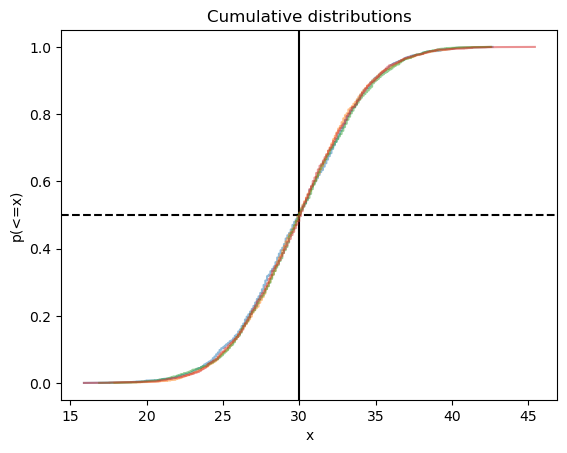

In [51]:
ui.plot_cdf(res_10_bkg, alpha=0.5)
ui.plot_cdf(res_100_bkg, alpha=0.5, overplot=True)
ui.plot_cdf(res_500_bkg, alpha=0.5, overplot=True)
ui.plot_cdf(res_1000_bkg, alpha=0.5, overplot=True)

plt.axhline(0.5, color='k', linestyle='dashed')
plt.axvline(source_rate, color="k")
plt.title("Cumulative distributions");

Hopefully this has shown how you can use Sherpa to check whether your fit results can be biased by your analysis choices (the [Handbook of X-ray Astronomy](https://doi.org/10.1017/CBO9781139034234.001) by Arnaud, Smith, and Siemiginowska is a good resource for those interested in this topic).